---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

A good business strategy for revenue growth is customer retention. One study has previously demonstrated that **80%** of a business' future profits will come from ***just* 20%** of the company's existing customers<sup><a href="https://smallbiztrends.com/2016/10/customer-retention-statistics.html">1</a></sup>. Also, when comparing to the acquisition of new clients, customer retention is estimated to be 5-25 times cheaper<sup><a href="https://hbr.org/2014/10/the-value-of-keeping-the-right-customers">2</a></sup>. This where churn and churn rates come in.

<p align=center>
<img src="img/money_loss.jpg" width="50%"><br>
<i><sup>Image credits: upklyak (<a href="https://br.freepik.com/vetores-gratis/queda-da-venda-da-recessao-economica-da-crise-financeira_29942020.htm">www.freepik.com</a>)</sup></i>
</p>

### What is Churn?

Churn represents the number of clients, while the *churn rate* refers to the percentage of users, that have been lost to the company over a determined period of time. That is:

**Churn Rate** = $C_B - C_E \over C_B$ $\times 100$, where $C_B$ is the number of customers at the beginning of the period and $C_E$ is the number of customers at the end of the period.

For telecom companies, the churn rate has been estimated at 1.9-2.1% monthly, and 10-67% annually<sup><a href="http://www.dbmarketing.com/telecom/churnreduction.html">3</a></sup>. These high churn rates demonstrate why it is important for companies to identify potential *churners* in order to try to prevent this loss of revenue. In this notebook, we will analyse a churn dataset from such a company and employ machine learning strategies to prevent potential churners.

# Getting the data

The data that is used in this project were originally publish as part of [IBM Developer's learning platform](https://developer.ibm.com/tutorials/watson-studio-using-jupyter-notebook/) and is also available on [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn). It contains information about customers who left within the last month of the analysed period and other customer information (demographics, account information, services that were signed up).

In [247]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pywaffle import Waffle
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler

# Getting the data
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Checking first entries of the dataset
df.head()

# Life, the Universe, and Everything
np.random.seed(42)

# defining plot parameters
#plt.style.use('dark_background')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.stretch'] = 'normal'
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.variant'] = 'normal'

## Data variables

As mentioned previously, the dataset contains several columns providing information about the customers:

* `customerID` = Unique ID for each customer.
* `gender` = The customers identified gender.
* `SeniorCitizen` = Wether the customer is a senior citizen (1) or not (0).
* `Partner` = Wether the customer has a partner (Yes) or not (No).
* `Dependents` = Whether the customer has dependents (Yes) or not (No).
* `tenure` = Number of months the customer has stayed with the company.
* `PhoneService` = Whether the customer has a phone service (Yes) or not (No).
* `MultipleLines` = Whether the customer has multiple lines (Yes) or not (No *or* No phone service).
* `InternetService` = Customer’s internet service provider (DSL, Fiber optic, No).
* `OnlineSecurity` = Whether the customer has online security (Yes) or not (No *or* No internet service).
* `OnlineBackup` = Whether the customer has online backup (Yes) or not (No *or* No internet service).
* `DeviceProtection` = Whether the customer has device protection (Yes) or not (No *or* No internet service).
* `TechSupport` = Whether the customer has tech support (Yes) or not (No *or* No internet service).
* `StreamingTV` = Whether the customer has streaming TV (Yes) or not (No *or* No internet service).
* `StreamingMovies` = Whether the customer has streaming movies (Yes) or not (No *or* No internet service).
* `Contract` = The contract term of the customer (Month-to-month, One year, Two year).
* `PaperlessBilling` = Whether the customer has paperless billing (Yes) or not (No).
* `PaymentMethod` = The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)).
* `MonthlyCharges` = The amount charged to the customer monthly.
* `TotalCharges` = The total amount charged to the customer.
* `Churn` = Whether the customer churned (Yes) or not (No).

## Data Preparation

### Exploratory analysis

First, we will begin by looking at the variables and their characteristics (type, missing values and descriptive statistics) and the dataset size.

In [145]:
# Listing data types, null values and size of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [146]:
# Checking unique values
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Here, no columns present null values and `TotalCharges` column is supposed to be float type but is set as object. Also, several columns are binary or with multiple values representing categories that need to be treated as such (need to be encoded). Upon trying to convert `TotalCharges` to numeric:

In [147]:
# Trying to convert column
#df['TotalCharges'].astype('float64')

We face an error:
> `ValueError: could not convert string to float: ''`

This means that instead of null values, the empty values were filled as an empty string, which generates an error. For this reason, we will convert all empty strings to null values and see what we get:

In [148]:
# R7eplacing empty string or records with only spaces with NaN
df_clean = df.replace(r'^\s*$', np.NaN, regex=True)
print('Empty values in "TotalCharges" column: {}'.format(df_clean['TotalCharges'].isnull().sum()))

Empty values in "TotalCharges" column: 11


Since these represent very few empty data points, we are going to replace the missing values with the median from the `TotalCharges` column, which represents a measurement less sensitive to outliers in the data.

In [149]:
# Getting the column median
median_TotalCharges = df_clean.TotalCharges.median()

# Replacing values
df_clean['TotalCharges'].fillna(median_TotalCharges, inplace=True)

# Converting to float
df_clean['TotalCharges'] = df_clean['TotalCharges'].astype('float64')

# Checking empty values again
print('Empty values in "TotalCharges" column: {}'.format(df_clean['TotalCharges'].isnull().sum()))

Empty values in "TotalCharges" column: 0


Now, we describe the numeric columns using descriptive statistics:

In [150]:
# Summary Statistics
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


From this, it appears that the dataset does not contain outliers. Let's check this fact by using boxplots.

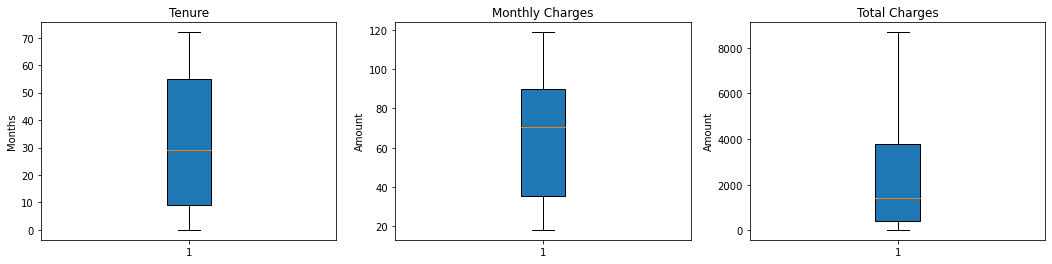

In [151]:
## Creating botplots of numeric data

# Defining suplots
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# Creating boxplots in each ax
axs[0].boxplot(df_clean['tenure'], notch=0, vert=1, whis=1.5, patch_artist=True)
axs[1].boxplot(df_clean['MonthlyCharges'], notch=0, vert=1, whis=1.5, patch_artist=True)
axs[2].boxplot(df_clean['TotalCharges'], notch=0, vert=1, whis=1.5, patch_artist=True)

# Adding titles
axs[0].set(title='Tenure', ylabel='Months', xlabel='')
axs[1].set(title='Monthly Charges', ylabel='Amount', xlabel='')
axs[2].set(title='Total Charges', ylabel='Amount', xlabel='');

With these, we confirm that there are no outliers in our data. It does us good to see how our variables are distributed.

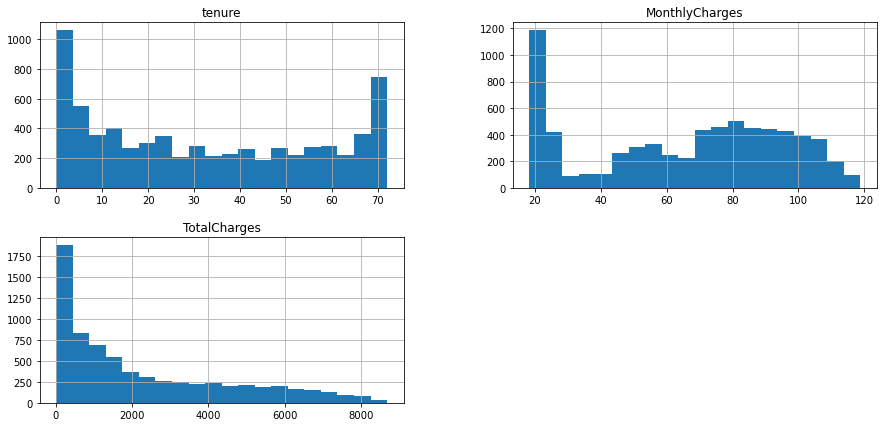

In [152]:
# Histograms of numeric variables
df_clean[['tenure', 'MonthlyCharges', 'TotalCharges']].hist(figsize=(15,7), bins = 20);

Overall, we can see that the distribution of values are skewed towards their ends. The `tenure` variable, representing the months of fidelity with the service, seems to indicate varying degrees of customer retention, while most of the customers appears to stay for very few months within the service even though we have a high number of customers staying longer.

`MonthlyCharges` indicate that there are varying degrees of charges, ultimately depending on how many services the client pays for. While those who pay fewer charges seem to dominate the data, the collective number of clients that pays for more services (mostly in the middle range) outnumbers those paying for less services. 

`TotalCharges` on the other hand shows that most charges stay in the lower end of the data range.

Another aspect which is important when dealing with datasets with categorical variables is the number of unique in each column.

In [153]:
# Defining function to print nice table
def uniqueValuesPerColumn(df):
    """
    Takes a dataframe and counts unique values in each
    categorical column of the dataset.
    """
    
    variables = df.select_dtypes('object').columns.to_list()

    unique_values = []

    for variable in variables:
        unique_values.append(', '.join(df[variable].unique()))
    
    unique_df = pd.DataFrame({'Variable': variables,
                              'Unique values': unique_values})
    
    return(unique_df)

In [154]:
# First we drop customerID column
df_clean.drop("customerID", axis=1, inplace=True)

In [155]:
# Now getting unique values:
pd.set_option('display.max_colwidth', None)
uniqueValuesPerColumn(df_clean)

,Variable,Unique values
0,gender,"Female, Male"
1,Partner,"Yes, No"
2,Dependents,"No, Yes"
3,PhoneService,"No, Yes"
4,MultipleLines,"No phone service, No, Yes"
5,InternetService,"DSL, Fiber optic, No"
6,OnlineSecurity,"No, Yes, No internet service"
7,OnlineBackup,"Yes, No, No internet service"
8,DeviceProtection,"No, Yes, No internet service"
9,TechSupport,"No, Yes, No internet service"


At first glance, variables which contain `No`, `Yes` and `No internet service` as entries might seem to present an overlap between `No` and `No internet service`. This is untrue. Having one of those entries as `No` means that the customer might have internet service, while not having the especific additional serviced mentioned in the column. We can check this fact.

In [156]:
# Subsetting only those without internet service
df_noInternet = df_clean[df_clean['InternetService'] == 'No']

# Getting unique values from resulting dataset
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
uniqueValuesPerColumn(df_noInternet[cols])

,Variable,Unique values
0,OnlineSecurity,No internet service
1,OnlineBackup,No internet service
2,DeviceProtection,No internet service
3,TechSupport,No internet service
4,StreamingTV,No internet service
5,StreamingMovies,No internet service


In [157]:
# Subsetting only those with internet service
df_Internet = df_clean[df_clean['InternetService'] != 'No']

# Getting unique values from resulting dataset
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
uniqueValuesPerColumn(df_Internet[cols])

,Variable,Unique values
0,OnlineSecurity,"No, Yes"
1,OnlineBackup,"Yes, No"
2,DeviceProtection,"No, Yes"
3,TechSupport,"No, Yes"
4,StreamingTV,"No, Yes"
5,StreamingMovies,"No, Yes"


With this point proven, we leave these variables intact. Although this represents redundant information, changing these variables to `No` would provide incorrect information to our model.

Another point of interest is class imbalance. In our dataset, classes that might represent a influence in our dataset are the variables `gender` (which might affect some datasets, depending on context, but I do not believe this is the case for our current analysis) and our target variable, `Churn`. Let's check how these are distributed.

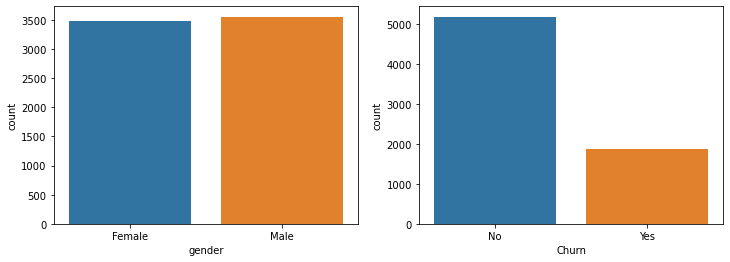

In [158]:
# Defining plots
fig, axs = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(x=df_clean.gender, ax=axs[0])
sns.countplot(x=df_clean.Churn, ax=axs[1]);


With these plots, we can see that `gender` does not represent an imbalance issue, but `Churn` does. Another aspect of our dataset that needs to be addressed is how the variables are coded. Since the categorical variables are strings, we will re-code them in our next session.

### Encoding categorical variables

Now, we recode our variables. Numerical variables will stay the same, while binary variables will be encoded using the `LabelEncoder` approach (including our target variable) and categorical variables with more than two entries will be transformed into dummy variables.

In [159]:
# Creating function to classify columns

def classifyColumns(df):
    """
    Takes a dataframe and returns which columns
    are numeric, binary categories or multiple
    categories, in this order.
    """

    num_cols = df.select_dtypes(['int64', 'float64', 'int32', 'float32']).columns.to_list()
    cat_cols = df.select_dtypes('object').columns.to_list()
    bcat_cols = []
    mcat_cols = []

    for col in cat_cols:
        if len(df[col].unique()) == 2:
            bcat_cols.append(col)
        elif len(df[col].unique()) > 2:
            mcat_cols.append(col)

    return num_cols, bcat_cols, mcat_cols


In [160]:
# Classifying columns with the function
num_cols, bcat_cols, mcat_cols = classifyColumns(df_clean)

# Copying df for backup
df_enc = df_clean.copy()

# Using LabelEncoder to code binary variables
le = LabelEncoder()
for col in bcat_cols:
    df_enc[col] = le.fit_transform(df_enc[col])

# Now getting dummies for categorical variables
df_enc = pd.get_dummies(df_enc, columns=mcat_cols)

# Checking resulting dataframe
df_enc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


## Machine Learning model

### Preliminary analysis

Given our data pre-processing, now we can proceed and build our Machine Learning model. At first, in order to assess which classification method would better fit our model at first glance, we will build a baseline comparison where no hyperparameter or feature will be changed.

The data will be split so the test data is isolated from the train/validation data in which we will build and test our models. Since we are using an imbalanced dataset, we use a *stratified sampling* approach when splitting the dataset in order to preserve relative class frequencies. For balancing the dataset, we will use the **Random Under Sampling** (RUS) approach, from the *imbalanced-learn* library, to randomly select samples from the default class. More on RUS can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html). This will improve our recall rates, which will be the evaluation metric of choice due to imbalance. Before doing so, we also standardize the data.

In [161]:
# Extracting target from dataset
X = df_enc.drop('Churn', axis=1)
y = df_enc['Churn']

# Separating train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)

# Standardizing data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Random Under Sampling
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [162]:
# Creating our evaluation function
def crossValClassModels(X, y, scaler, metric):
    """
    Makes cross validation data using multiple
    classification models for a baseline.

    Takes:
        X = Dataframe of independend variables.
        y = Series of the target variable.
        scaler = Scaling method used to 
                 transform/normalize the data
        metric = Metric chosen to evaluate models.

    Returns a dataframe with 'metric' results for
    each predefined model, with standard error.
    """

    # List to build results df later
    model_name = []
    metric_result = []
    elapsed_time = []
    start_time = datetime.now()


    # Converting to arrays
    X = np.array(X)
    y = np.array(y)

    # Initiating models
    lg = LogisticRegression()
    dtc = DecisionTreeClassifier() 
    rf = RandomForestClassifier()
    svm = SVC() # Support Vector Machines
    sgd = SGDClassifier() # Stochastic Gradient Descent
    lgbm = LGBMClassifier() # LightGBM
    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss") #XGBoost, parameters to supress warnings

    # Creating list of results
    models = [lg, dtc, rf, svm, sgd, lgbm, xgb]

    # Looping and evaluating each model
    for model in models:
        pipeline = make_pipeline(scaler, model)
        scores = cross_val_score(pipeline, X, y, scoring = metric)
        model_name.append(model.__class__.__name__)
        metric_result.append("{:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))
        elapsed_time.append((datetime.now()-start_time).total_seconds())
        start_time = datetime.now()

    metric_name = metric.capitalize()
    results_df = pd.DataFrame({'Model': model_name,
                                metric_name: metric_result,
                                'Elapsed time': elapsed_time})

    return(results_df)

In [163]:
# Executing it in our traning data
crossValClassModels(X_train_rus, y_train_rus, StandardScaler(), 'recall')

,Model,Recall,Elapsed time
0,LogisticRegression,0.7982 (+/- 0.0385),0.095622
1,DecisionTreeClassifier,0.6883 (+/- 0.0114),0.052334
2,RandomForestClassifier,0.7575 (+/- 0.0340),1.053639
3,SVC,0.7796 (+/- 0.0389),1.008830
4,SGDClassifier,0.7182 (+/- 0.0977),0.084799
5,LGBMClassifier,0.7710 (+/- 0.0180),0.466964
6,XGBClassifier,0.7589 (+/- 0.0188),0.678631


Based on these preliminary results, we can see that the `LGBMClassifier` outperforms other methods when we consider `recall` and its standard deviation as well as the time it took to run the calculations. Our best `recall` was found in the `LogisticRegression` model, but it offers few parameters for model tunning in comparison with the gradient boosting model LightGBM. Since LightGBM is said to not perform well in datasets below the 10,000 observations count, we will use a model that was similarly effective in these results, which is the `XGBClassifier`, or XGBoost.

### XGBoost model tunning

One of the issues when trying to classify data using Machine Learning is *overfitting*. This occurs when you have high training accuracy, but your test accuracy actually is considerably lower. This happens because the model fitted too close to the training data, and may fail to actually predict the outcome in the test dataset. To deal with that, there are a few parameters that we can tune according to [XGBoost's documentation](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html) to avoid overfitting:

* Changing complexity parameters = `max_depth`, `min_child_weight` and `gamma`.
* Adding randomness (noise robustness) = `subsample`, `colsample_bytree` and `eta` (reducing it requires increase in `num_round`).

A good start point in gradient boosting models is to tune the learning rate (`learning_rate`) and the number of estimators (`n_estimators`) in the model. After adjusting for those, we will adjust the complexity parameters. We will not add randomness to the model since we have yet to see how our model will perform on test data. These steps will be made through a Grid Search Cross Validation approach.

In [164]:
# Initiating our model with base learning rate
xgb = XGBClassifier(learning_rate=0.1, eval_metric='logloss', use_label_encoder=False)

# Parameters grid
param_grid = {
    'n_estimators': range(0, 1000, 50)
}

# KFold stratification
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Creating our grid search
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
search_results = grid_search.fit(X_train_rus, y_train_rus)

In [165]:
# Checking results
print("Best score was: {:.2f} for {}".format(search_results.best_score_, search_results.best_params_))

Best score was: 0.78 for {'n_estimators': 50}


Seeing that 50 is gave the best score, we reinitialize our model using these parameters and look for others.

In [166]:
# Initiating our model with base learning rate and n_estimators
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50, eval_metric='logloss', use_label_encoder=False)

# Parameters grid
param_grid = {
    'max_depth': range(1, 10, 1),
    'min_child_weight': range(1, 5, 1),
    'gamma': [i/10 for i in range(0,5)]
}

# KFold stratification
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Creating our grid search
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
search_results = grid_search.fit(X_train_rus, y_train_rus)

In [167]:
# Checking results
print("Best score was: {:.2f} for {}".format(search_results.best_score_, search_results.best_params_))

Best score was: 0.82 for {'gamma': 0.0, 'max_depth': 1, 'min_child_weight': 1}


Now we estimate the better value for `learning_rate`:

In [168]:
# Initiating our model with base learning rate and n_estimators
xgb = XGBClassifier(max_depth=1, min_child_weight=1, gamma=0, n_estimators=50, eval_metric='logloss', use_label_encoder=False)

# Parameters grid
param_grid = {
    'learning_rate': [1/i for i in [10**j for j in range(0,4)]],
}

# KFold stratification
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Creating our grid search
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
search_results = grid_search.fit(X_train_rus, y_train_rus)

In [169]:
# Checking results
print("Best score was: {:.2f} for {}".format(search_results.best_score_, search_results.best_params_))

Best score was: 0.89 for {'learning_rate': 0.01}


We can see that changing these parameters improved our model substantially. We could try further enhancements in parameter tunning, but we already have a good recall score for our model. Thus, to avoid overfitting, we will proceed to the test phase.

### Testing our model

Now let us do the testing.

In [170]:
# Instantiating our classifier with found parameters
xgb = XGBClassifier(max_depth=1, min_child_weight=1, gamma=0, n_estimators=50, 
                    learning_rate=0.01, eval_metric='logloss', use_label_encoder=False)

# Fitting our test data
xgb.fit(X_train_rus, y_train_rus)

# Predicting
X_test_backup = X_test.copy()
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

After fitting and predicting, we check our metrics:

In [171]:
# Classification report
print(classification_report(y_test, y_pred))

# Calculating ROC AUC score
print("     ROC AUC       {:.2f}".format(roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.93      0.57      0.71      1294
           1       0.43      0.89      0.58       467

    accuracy                           0.66      1761
   macro avg       0.68      0.73      0.64      1761
weighted avg       0.80      0.66      0.67      1761

     ROC AUC       0.73


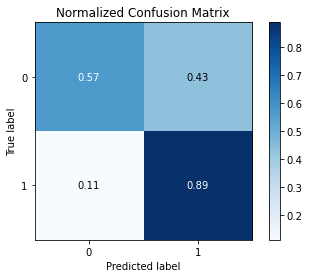

In [172]:
# Confusion matryx
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

We can see that in our test phase we have obtained similar results to those of the training model. The **recall**, or sensitivity, is the ability of our model to correctly identify all positive cases. Although there is definitely room for improvement (with feature selection/engineering or further tunning of hyperparamenters), we have achieved good recall rates both in train and test phases. But what does 89% recall rate means here? How does that relate to Churn and Churn rate?

## Churn Rate

As mentioned in the beginning, **Churn Rate** represents the percentage of clients that have left the company service over a analysed period of time. For telecom companies, the churn rate has been estimated at 1.9-2.1% monthly, and 10-67% anually<sup><a href="http://www.dbmarketing.com/telecom/churnreduction.html">3</a></sup>. Another useful KPI for evaluating Churn is the **Gross MRR Churn Rate**. The Gross *Monthly Recurring Revenue* Churn Rate is, in turn, the percentage of revenue lost by the company due to Churn of clients<sup><a href="https://www.geckoboard.com/best-practice/kpi-examples/gross-mrr-churn-rate/">4</a></sup>.

These KPIs can be calculated by the following:

**Churn Rate** = $C_B - C_E \over C_B$ $\times 100$, where $C_B$ is the number of customers at the beginning of the period and $C_E$ is the number of customers at the end of the period.

**Gross MRR Churn Rate** = $MRR_C \over MRR_T$ $\times 100$, where $MRR_C$ is the MRR lost due to churn in that month and $MRR_T$ is the total MRR there would be without the loss of clients for that period.

So, let's see how these metrics apply to our model.

In [216]:
# Creating function to calculate our metrics
def calcChurnKPIs(y_test, y_pred, X_test, value_column):
    """
    Function to calculate Churn Rate and Gross MMR Churn Rate.
    Takes as arguments the y_test and y_pred from final model,
    the X_test (w/ column names! be careful when using scaler!)
    and value_column as the name of column with MRR variable.
    """

    # Creating dict
    predictions = {'Index': y_test.index.values,
                   'Amount': X_test[value_column],
                   'Class': y_test.to_numpy(),
                   'Model Prediction': y_pred,
                   'Catch': ""
                   }

    # Converting to df
    predictions_df = pd.DataFrame(predictions).reset_index()

    # Looping to identify churners
    for i in range(predictions_df.shape[0]):
        if predictions_df.loc[i, 'Class'] == 1:
            if predictions_df.loc[i, 'Class'] == predictions_df.loc[i, 'Model Prediction']:
                predictions_df.loc[i,'Catch'] = 'Detected Churn'
            else:
                predictions_df.loc[i,'Catch'] = 'Undetected Churn'
        elif predictions_df.loc[i, 'Class'] == 0 and predictions_df.loc[i, 'Model Prediction'] == 1:
            predictions_df.loc[i,'Catch'] = 'Detected, not Churn'
        else:
            predictions_df.loc[i,'Catch'] = 'Not churn'

    # Extracting information
    n_customer = len(y_test)
    n_churn = predictions_df.Catch.value_counts()['Detected Churn'] + predictions_df.Catch.value_counts()['Undetected Churn']
    n_churn_detected = predictions_df.Catch.value_counts()['Detected Churn']
    total_mrr = predictions_df.Amount.sum()
    churn_mrr = predictions_df.loc[predictions_df['Catch'] == 'Detected Churn'].Amount.sum() + predictions_df.loc[predictions_df['Catch'] == 'Undetected Churn'].Amount.sum()
    churn_mrr_detected = predictions_df.loc[predictions_df['Catch'] == 'Detected Churn'].Amount.sum()

    # Creating kpi dictionary
    kpis_dict = {'KPI': ['Churn Rate', 'Gross MRR Churn Rate', 'Gross MRR Loss'],
                 'Real': ["{:.2%}".format(n_churn/n_customer),
                          "{:.2%}".format(churn_mrr/total_mrr),
                          "${:,.2f}".format(churn_mrr)],
                 'Detected': ["{:.2%}".format(n_churn_detected/n_customer),
                              "{:.2%}".format(churn_mrr_detected/total_mrr),
                              "${:,.2f}".format(churn_mrr_detected)],
                 'Difference': ["{:.2%}".format((n_churn/n_customer)-(n_churn_detected/n_customer)),
                                "{:.2%}".format((churn_mrr/total_mrr)-(churn_mrr_detected/total_mrr)),
                                "${:,.2f}".format(churn_mrr-churn_mrr_detected)]}

    # Converting to dataframe
    kpis_df = pd.DataFrame(kpis_dict)

    print("Gross MRR for the period analysed: ${:,.2f}".format(total_mrr))
    return(kpis_df)

In [217]:
calcChurnKPIs(y_test, y_pred, X_test_backup, 'MonthlyCharges')

Gross MRR for the period analysed: $113,543.90


,KPI,Real,Detected,Difference
0,Churn Rate,26.52%,23.51%,3.01%
1,Gross MRR Churn Rate,30.22%,26.16%,4.06%
2,Gross MRR Loss,"$34,315.40","$29,704.05","$4,611.35"


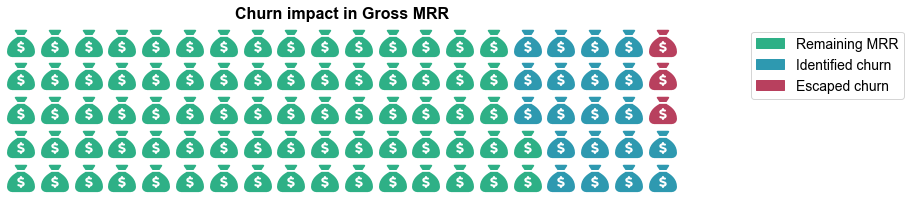

In [268]:
# Plotting results
fig = plt.figure(FigureClass=Waffle,
                 figsize=(12,4),
                 rows=5,
                 columns=20,
                 title={'label': 'Churn impact in Gross MRR', 
                        'loc': 'center', 
                        'fontdict': {'fontsize': 16, 'fontweight': 'bold'}},
                 colors=('#2EB086', '#2E99B0', '#B8405E'),
                 icons='sack-dollar',
                 values={'Remaining MRR': 113543.9,
                         'Identified churn': 29704.05,
                         'Escaped churn': 4611.35},
                 legend={'loc': 'upper left',
                         'bbox_to_anchor': (1.1, 1),
                         'fontsize': 14},
                )

fig.set_tight_layout(False)
plt.show()

From these results, it can be seen that we were able to identify most of the churners in this dataset. From churners in the dataset, we identified 23% out of 26% churners (3% difference from the real number of churners), which would represent $29,704.05 of the Gross MRR.

## Conclusion

Overall, without putting much effort in tuning hyperparameters, we were able to obtain recall rates of 89% in both train and test data. With this, we were able to identify 23% out of 26% churners in the dataset. Company strategies aiming to retain these customers could prevent the loss of $29,704.05 monthly. This represents a great prospect for companies that deal with high churn. 

The dataset page on Kaggle specifies that the churn data represents churners that left within the last month of the time span analysed. This means that our data has a month Churn Rate a lot higher (26.5%) than average (1.9-2.1%). 

Supposing the company was able to retain all the churners previously identified by our model, this would mean a reduction of Churn Rate from 26% to roughly 3%. Although this is still higher than average, it represents a substantial improvement and opens the way to implement further strategies to reduce revenue loss by the company. Thus, we conclude that our model would have a positive impact in implementing strategies against churn rate in this dataset.

# References
1: https://smallbiztrends.com/2016/10/customer-retention-statistics.html

2: https://hbr.org/2014/10/the-value-of-keeping-the-right-customers

3: http://www.dbmarketing.com/telecom/churnreduction.html

4: https://www.geckoboard.com/best-practice/kpi-examples/gross-mrr-churn-rate/